# Connectivity Tests for Safety of CAVs

### Scenario

A vehicle is moving forward while being connected to $N-1$ peers. Each peer $i$ is sending a timestamped message $m^{(n)}_t$ containing important information about the shared space, i.e. environment state. At some point $t_e$ an event occur that will eventually lead to an unwanted outcome, e.g. collision. To avoid collision we use the incoming messages to detect the causal event. Consequently, the vehicle must process all messages in the *safety-critical function* $F(m^{(1)}_t, m^{(2)}_t, ...)$. When $F$ has detected the event it starts braking the vehicle. We assume the ego vehicle travels at a constant velocity $v$ straight towards the eventual collision from the start of the scenario. In fact, with the vehicle starting at $x=x_0$ and the collision happening at $x=0$, we can set the vehicle dynamics to simply be $\dot{x} = v$. With $t$ growing backwards in time we start the scenario at $t=t_0$ and end it with the eventual collision (assuming the vehicle never brakes) at $t=0$, i.e. $v = \frac{x_0}{t_0}$.

```
    Start       Event   Collision
    .           .       |
    .           .       |
[Ego]=>         .       |
    .           .       |
    .           .       |
    t=t0        t=te    t=0

(P-1)
(P-2)
```

### Safety

The main goal of the vehicle is to remain safe and brake in time. However, safety depends of course on many things like the connectivity, the ability to react and the event itself. Since these tests focus on connectivity we will simplify $F$ accordingly. Firstly, as previously stated, $F$ requires the incoming messages. We will also use some fundamental assumptions about the ability to react, e.g. the only way to avoid collision is to brake, and we will not consider some more nuanced perspectives like how braking changes the velocity that in turn affect the internals of $F$ (what it means to be safe). That means $F$ is fundamentally a construction for requiring connectivity. However, we must still define what it means to be safe. When should $F$ be computed? Can, and if so, should $F$ be computed multiple times?

For simplicity we first assume that the ego vehicle is scheduled to compute $F$ on a clock with fixed interval $T_c$. We then define safety (over the entire test) as the following:

    SAFETY CRITERION
    ----------------
    The safety-critical function F is computed 
        (R1) on all
        (R2) on at least one 
    scheduled executions after the causal event.
    
We can choose to look through one of two perspectives by choosing either requirement `R1` or `R2`. Neither is more correct than the other since this detail inherently depends on the implementation of $F$. For convenience we call the two variations *strong-safety* and *weak-safety* respectively. However, remember that the safety in this case is only up until the connectivity requirements set up for these tests. In a broader scope these conditions **do not** satisfy safety since that would entail requirements on all layers of the system in question.

### Compute Time

The computation time of $F$ is for simplicity assumed to be the same as the scheduling interval, i.e. $T_c$. In reality, however, the computation time might depend on multiple variables. One such dependency could be the number of peers in the scenario. To incorporate this behavior we assume that the compute time (somehow) scales with the number of peers.

$$T_c = T \cdot N^{K}$$

With this we can describe $T_c$ in terms of $T$ and how the computation changes with more peers.

### Braking Distance

An important factor in deciding whether we will collide or not is the braking distance. This is a measure of the latest possible time we can react depending on the current velocity. The braking distance, in `[m]`, is roughly equal to 

$$ l_b = \frac{v^2}{250\mu} $$

where $v$ is the velocity in `[km/h]` and $\mu$ is the friction number. The friction number is typically $\mu=0.8$ for dry asphalt and $\mu=0.1$ for smooth ice. 

In these experiments we could cautiously set $f=0.6$ and get the following approximate table:

| Velocity `[m/s]` | Braking distance `[m]` |
|------------------|------------------------|
| 5                | 2.1                    |
| 10               | 8.6                    |
| 20               | 34.5                   |

With the braking distance we can more specifically and formally define unsafe situations. For instance, consider the collision point $x=0$. After calculating the braking distance we can say that if the ego vehicle were to enter $x<l_b$ it will not stop in time and ultimately collide. We call $x<l_b$ the *collision zone* $Z_C$ and updates the safety criterion accordingly.

    SAFETY CRITERION
    ----------------
    The safety-critical function F is computed 
        (R1) on all
        (R2) on at least one 
    scheduled executions after the causal event,
    AND,
    the vehicle never enters the collision zone.

### Connectivity & Safety

The most central question in these tests is "How does connectivity relate to safety?". As stated previously, the safety criterion only depends on the computations of $F$ which in turn only depends on the incoming messages $m^{(n)}$. Consequently, we should investigate what affects the connectivity and how the messages will be delivered.

The communication medium is a wireless network. The network will add some latency which must be considered in any sort of safety criteria. Furthermore, this latency is affected by both the size $D$ and frequency $f$ of the messages. The communication architecture $A$ also affects the setup. For example, if the peers are in a direct P2P network then the latency will probably decrease compared to a centralized server based architecture.

For one execution of $F$, scheduled at time $t$, there will be a total *reaction time* $\tau_r$ from the latency $L(m_t')$ of a message and the computational time $T_c$. There will also be a slight delay $\delta$ due to scheduling differences between the receiving a message and the computation of $F$. For a direct P2P architecture the reaction time will be

$$
\tau^{(t)}_r = \max_n{L_a(m^{(n)}_{t'_n})} + T_c,
$$

where $t$ is the time at which $F$ is scheduled and computed (we assume computation occurs at the exact scheduled time), $t'_n$ is the time at which the latest received message $m^{(n)}$ was sent, and finally, $L_a(m) = t - t'$ is the apparent latency. The reaction time $\tau^{(t)}_r$ can be seen as a headway window moving along with the vehicle; if anything would occur inside this time window then the vehicle will not be able to react in response to the event (make a decision).

Furthermore, with the braking distance in mind and considering the reaction time, we can define the *dangerous zone* $Z_D$ of the vehicle. This zone constitutes the space in front of the vehicle with a length $l_d = v\tau_r + l_b$. If anything would occur inside this zone, even if the vehicle could detect it, it would not be able to stop in time. In other terms we want that $x-l_d>0$, or in headway time, $\tau > \tau_r + \frac{l_b}{v}$. 

    SAFETY CRITERION
    ----------------
    The safety-critical function F is computed 
        (R1) on all
        (R2) on at least one 
    scheduled executions after the causal event,
    AND,
    the collision point is never in the dangerous zone.
    
Following is an illustration of both the dangerous zone and the collision zone.

```
    Start   ZD              ZC  Collision
    .       .               .   |
    .       .               .   |
[Ego]=>     .               .   |       
    .       .               .   |
    .       .               .   |
x:  x0      x0-ld           lb  0
```

### Test Case

A test case executes a simulated run of the described scenario. The simulation is run in discrete time $k$ with timesteps $h=0.1$ seconds. The vehicle dynamics are defined by $x_{k+1} = x_k + vh$. Note that each vehicle simulates their own run and have their own discrete time, e.g. $k_{ego}$. This requires that the vehicles are time synchronized.

Each test case $\mathbf{T_i}$, indexed by $\mathbf{i}$, is defined by a configuration parameters $\mathbf{P_i}$ and produces logs for all vehicles. The configuration parameters could be structured as a 7-tuple $\mathbf{P} = (N, x_0, v, f, D, T, K)$ for the corresponding variables discussed earlier.

In [2]:
## Setup ##

from dataclasses import dataclass
from pathlib import Path


TESTSUITE = '1677842927085477113'

PROJ_DIR = Path().absolute().parent
TESTSUITE_DIR = PROJ_DIR / 'log' / TESTSUITE
print(f'Chosen directory: {TESTSUITE_DIR.absolute()}')

FIELDS = {
    'sender':    str,
    'sent':      int,   # [ns]
    'arrival':   int,   # [ns]
    'valid':     bool,
    'headway':   float, # [s]
    'connected': bool,
}

FIELD_SEP = ','
ENTRY_SEP = ';'

FRICTION = 0.6


def is_strong_safe(df):
    return False


def is_weak_safe(df):
    return False


@dataclass
class Conf:
    
    AGENTS: int      # [1]
    INIT_POS: float  # [m]
    TARG_VEL: float  # [m/s]
    TIME_STEP: float # [s]
    DATA_SIZE: float # [kB]
    DATA_FREQ: float # [Hz]
    COMP_TIME: float # [s]
    COMP_ORDR: float # [1]
        
    @property
    def compute_time(self):
        return (
            self.COMP_TIME
            * len(self.AGENTS)**self.COMP_ORDR
        )
    
    @property 
    def latest_braking_time(self):
        return self.TARG_VEL / (250*FRICTION)

Chosen directory: /home/kaarmu/Projects/wp3_tests/src/wp3_tests/log/1677842927085477113


In [3]:
## Import Test Cases ## 

import json

import numpy as np
import pandas as pd

cfs = {} # { test: configuration }
dfs = {} # { (test, vehicle): dataframe }
for path in TESTSUITE_DIR.iterdir():
    test = path.name
    for filepath in path.iterdir():
        with open(filepath) as f:
            if filepath.name == 'conf':
                cfs[test] = Conf(**json.load(f))
            else:
                vehicle = filepath.name
                dfs[test, vehicle] = pd.read_csv(f, 
                                                 names=FIELDS,
                                                 dtype=FIELDS,
                                                 lineterminator=ENTRY_SEP)

print(f'Collected {len(dfs)} number of testcases')

Collected 2880 number of testcases


## Latency vs Throughput

**Background**: If the data received is critical for safe operation of the ego vehicle, one obvious problem is the reliance on the connection. The vehicle would/could become unsafe if the network partition (splits). In some sense latency could be the source of network partitioning (a sort of partitioning is when the latency becomes "too large" for the application). With increased throughput there is increased demands on the network which could be a source of latency. Throughput (size of messages times frequency) is, however, important for the vehicle. Therefore it is interesting to look at how latency vs. data throughput affects the safety conditions we have set up.

**Expected Result**: Increasing latency or throughput should eventually lead to unsafe scenarios.

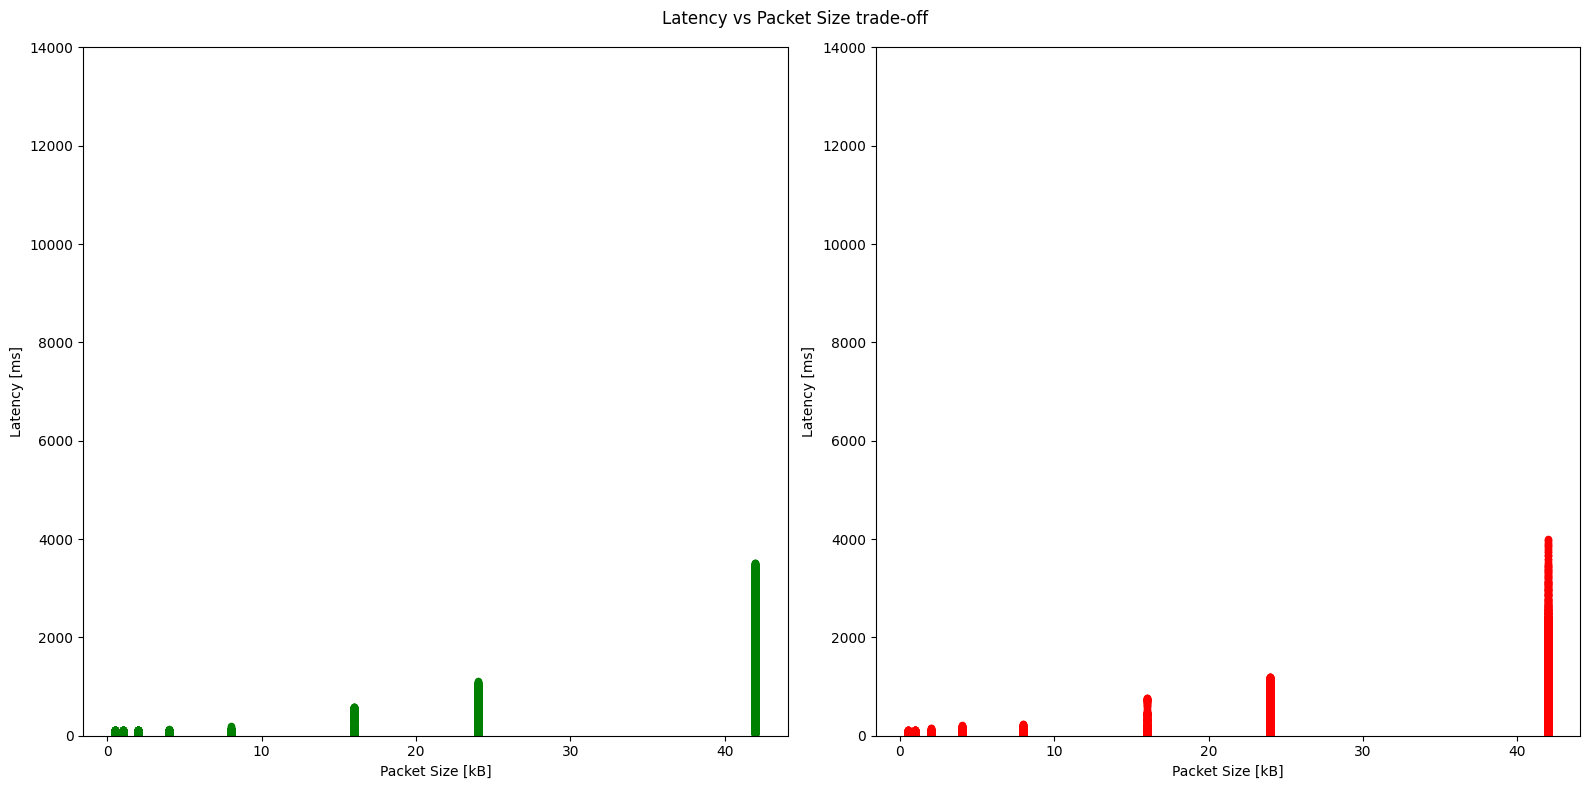

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2'

fig, axs = plt.subplots(1, 2, figsize=(16,8))
fig.set_tight_layout(True)

safe, unsafe = pd.DataFrame(), pd.DataFrame()
for test, vehicle in dfs:
    
    cf = cfs[test]
    df = dfs[test, vehicle]
    
    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    elif df.empty:
        print(f'Warning: Log for {(test, vehicle)} is empty')
        continue
        
    headway = df['headway']

    is_safe = roi['connected'].all()
    
    new = pd.DataFrame({
        'packet_size': cf.DATA_SIZE,
        'latency': (roi['arrival'] - roi['sent']) / 1e6, # [ms]
    })
        
    if is_safe:
        safe = pd.concat([safe, new], ignore_index=True)
    else:
        unsafe = pd.concat([unsafe, new], ignore_index=True)

safe.plot.scatter(x='packet_size', y='latency', c='green', ax=axs[0])
unsafe.plot.scatter(x='packet_size', y='latency', c='red', ax=axs[1])

fig.suptitle('Latency vs Packet Size trade-off')

for ax in axs:
    ax.set_xlabel('Packet Size [kB]')
    ax.set_ylabel('Latency [ms]')
    ax.set_ylim([0, 14000])

None

## Computational Complexity

**Background**:
???

**Expected Result**: 
???

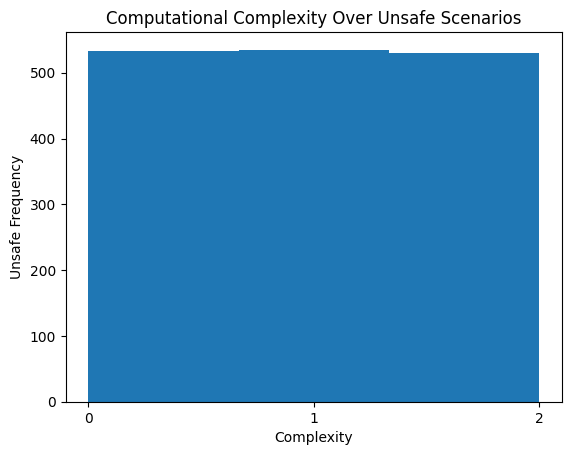

In [6]:
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2', 'svea5'

fig = plt.figure()
ax = fig.gca() 

res = pd.DataFrame()
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    
    df = dfs[test, vehicle]
    
    new = pd.DataFrame({
        'complexity': cfs[test].COMP_ORDR,
        'safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new.tail(1)], ignore_index=True)

safe = res[res['safe']]
unsafe = res[~res['safe']]

unsafe['complexity'].plot.hist(bins=3, xticks=(0, 1, 2), ax=ax)

ax.set_title('Computational Complexity Over Unsafe Scenarios')
ax.set_xlabel('Complexity')
ax.set_ylabel('Unsafe Frequency')

None

## How far does the vehicle go?

**Background**:
When the vehicle becomes unsafe, the vehicle will finish the test.
Thus, if we look at the headway at the last time step of each test
case then we can determine how near the intersection a vehicle can
go before becoming unsafe.

**Expected Result**:
That vehicles reach the intersection while being safe. 

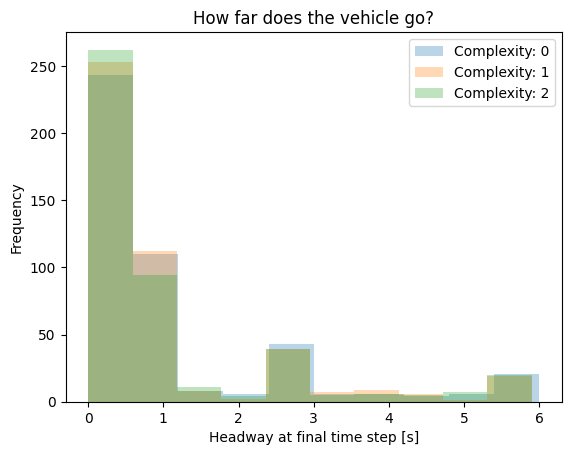

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2', 'svea5'

fig = plt.figure()
ax = fig.gca()

res = pd.DataFrame()
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    elif dfs[test, vehicle].empty: continue
    
    df = dfs[test, vehicle]    
    new = pd.DataFrame({
        'complexity': cfs[test].COMP_ORDR,
        'headway': df['headway'],
    })
    
    res = pd.concat([res, new.tail(1)], ignore_index=True)

for i in range(3):
    
    r = res[res['complexity'] == i]
    
    # safe = r[r['safe']]
    # unsafe = r[~r['safe']]
    
    r['headway'].plot.hist(alpha=0.3, label=f'Complexity: {i}', ax=ax)

ax.set_title('How far does the vehicle go?')
ax.set_xlabel('Headway at final time step [s]')
ax.legend()

None

## How far does the vehicle go?

**Background**:
Compare the actual compute time (i.e. including complexity) to the 
last headway time (i.e. a measure of distance to the intersection).

**Expected Result**:
Higher compute time should lead to higher number of unsafe scenarios.

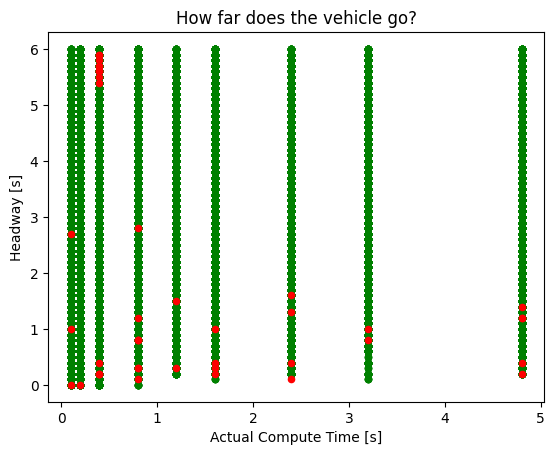

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea5'

fig = plt.figure()
ax = fig.gca()

res = pd.DataFrame()
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    elif dfs[test, vehicle].empty: continue
    
    df = dfs[test, vehicle]    
    new = pd.DataFrame({
        'compute_time': cfs[test].compute_time,
        'headway': df['headway'],
        'safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new], ignore_index=True)

safe = res[res['safe']]
unsafe = res[~res['safe']]
    
safe.plot.scatter(x='compute_time', y='headway', c='green', ax=ax)
unsafe.plot.scatter(x='compute_time', y='headway', c='red', ax=ax)

ax.set_title('How far does the vehicle go?')
ax.set_xlabel('Actual Compute Time [s]')
ax.set_ylabel('Headway [s]')

None

## Number of Crashes

**Background**:
Even if we loose connection to the internet, it is 
not certain that we crash! Instead of only looking 
at unsafe (which really means "not connected") we 
can look if the vehicle is unsafe before/after the 
minimum braking distance. The braking distance is 
roughly equal to 

$$ d = \frac{v^2}{250f} $$

where $d$ is the braking distance in `[m]`, $v$ is 
the velocity in `[km/h]` and f is the friction 
number. The friction number is typically $f=0.8$ for
dry asphalt and $f=0.1$ for smooth ice. 

In these experiments we could cautiously set 
$f=0.6$ and get the following approximate table:

| Velocity `[m/s]` | Braking distance `[m]` |
|------------------|------------------------|
| 5                | 2.1                    |
| 10               | 8.6                    |
| 20               | 34.5                   |


**Expected Result**:
???

## Velocity vs Throughput

**Background**: ???
    
**Expected Result**: ???

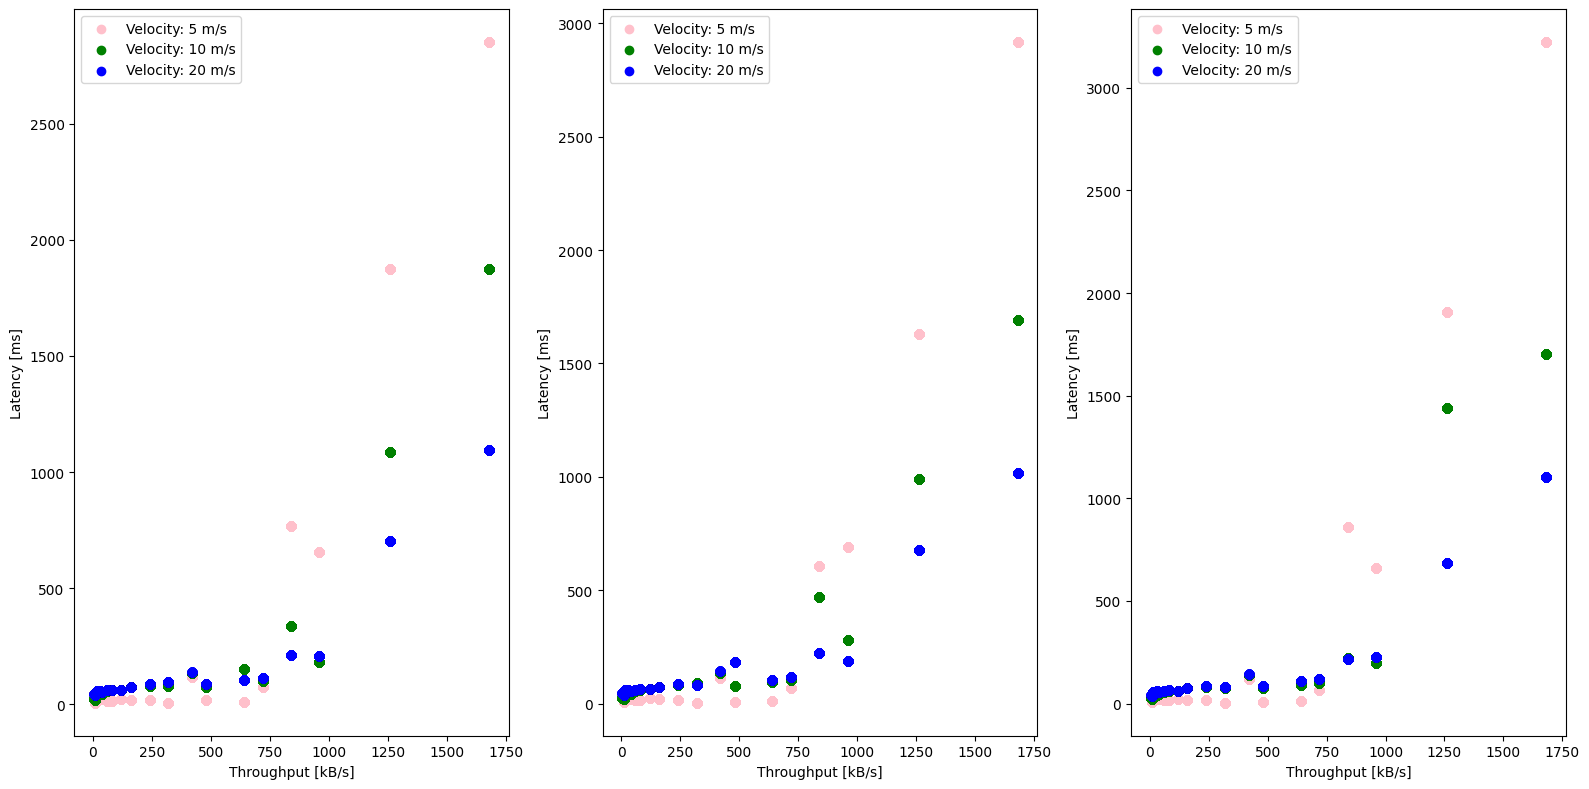

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2'

fig, axs = plt.subplots(1, 3, figsize=(16,8))
fig.set_tight_layout(True)

res = pd.DataFrame()
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    elif dfs[test, vehicle].empty: continue
    
    cf = cfs[test]
    df = dfs[test, vehicle]    
    new = pd.DataFrame({
        'complexity': cf.COMP_ORDR,
        'velocity': cf.TARG_VEL,
        'latency': (df['arrival'] - df['sent']) / 1e6, # [ms]
        'throughput': cf.DATA_SIZE * cf.DATA_FREQ,
        'safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new], ignore_index=True)

velocities = np.unique(res['velocity'])
colors = [
    'pink',
    'green',
    'blue',
]

for i, ax in enumerate(axs):
    mask_a = res['complexity'] == i
    
    for j, (v, c) in enumerate(zip(velocities, colors)):
        mask_b = res['velocity'] == v
        r = res[mask_a & mask_b]
        throughput = r['throughput'].to_numpy()
        latency = r['latency'].to_numpy()
        mean = np.zeros(latency.shape)
        
        for t in np.unique(throughput):
            mask = throughput == t 
            mean[mask] = latency[mask].mean()
            
        axs[i].scatter(throughput, mean, c=c, label=f'Velocity: {v} m/s')
    
    axs[i].set_xlabel('Throughput [kB/s]')
    axs[i].set_ylabel('Latency [ms]')
    axs[i].legend()
    
None

In [ ]:
unique_throughputs = conf_df["THROUGHPUT"].unique().tolist() # use as x-axis
target_vel = conf_df["TARG_VEL"].unique().tolist() # use as legend
comp_time_mean = conf_df["COMP_TIME"].mean()
ordos = conf_df["COMP_ORDR"].unique().tolist()

fig = plt.figure(figsize=(16,8),dpi=150)
fig.set_tight_layout(True)
for k, ordo in enumerate(ordos):
    ax = fig.add_subplot(1, len(ordos), k+1)
    for vel in target_vel:
        x_tp = []
        y_lat = []
        y_std = []
        unsafe = pd.DataFrame()
        for i, throughput in enumerate(unique_throughputs):
            test_cases = conf_df.loc[(conf_df["THROUGHPUT"] == throughput) & (conf_df["TARG_VEL"] == vel) & (conf_df["COMP_ORDR"] == ordo)].index.tolist()
            # Load all the test cases with the particular throughput and target_velocity
            svea2_df, svea5_df = pd.DataFrame(), pd.DataFrame()
            for test_case in test_cases:
                try:
                    _, svea2_loc_df, svea5_loc_df = load_test_case(TEST_SUITE,f"test_{test_case}")
                    svea2_df = pd.concat([svea2_df,svea2_loc_df])
                    svea5_df = pd.concat([svea5_df,svea5_loc_df])
                except Exception as e:
                    print("ERROR in:", test_case)

            x_tp.append(throughput)
            y_lat.append(svea2_df["LATENCY"].loc[svea2_df["IS_SAFE"]==True].mean())
            y_std.append(svea2_df["LATENCY"].loc[svea2_df["IS_SAFE"]==True].std())

            unsafe = pd.concat([unsafe, svea2_df.loc[svea2_df["IS_SAFE"]==False][["THROUGHPUT", "IS_SAFE", "LATENCY"]]])

        p = ax.errorbar(x_tp,y_lat, yerr=y_std, fmt="--o", label=r"$v_{target}=$"+str(vel))
        ax.plot(unsafe["THROUGHPUT"], unsafe["LATENCY"], "x", markersize=15, color=p[0].get_color() ,label="Unsafe")
        ax.plot(unsafe["THROUGHPUT"], unsafe["LATENCY"], "r.")
    
    ax.set_xlabel("Throughput [kB/s]")
    ax.set_ylabel("Latency [ms]")
    ax.set_title(f"Ordo {ordo}")
    ax.grid()
    ax.legend(loc="lower right")
plt.suptitle(f"Avg Compute Time {comp_time_mean:.2f} ms")
plt.savefig(TEST_SUITE+".png")

In [100]:
# first, second = res.iloc[:-1], res.iloc[1:]
# first["Headway"].to_numpy() < second["Headway"].to_numpy()

# bs = first["Headway"].to_numpy() >= second["Headway"].to_numpy()
# ns = ~(first["Safe"] & pd.Series(bs))

# first["Headway"]

dfs[test, vehicle].dtypes

print(np.float64('5.4'))

5.4
